In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.applications import MobileNetV2,Xception,EfficientNetB7,InceptionResNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input,LSTM, ConvLSTM2D, MaxPooling3D, TimeDistributed, Dense, Flatten, Dropout, Bidirectional, MaxPooling2D, InputLayer, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

from IPython.display import clear_output,Video

import os
import json
import cv2


In [2]:
IMG_SIZE = 128
FRAME_COUNT = 15

In [3]:
Video("C:\\Users\\manas\\Downloads\\violence_detection_dataset\\Real Life Violence Dataset\\Violence\\V_988.mp4",embed=True,width=400,height=400)

In [4]:
def load_video(path, nframes=FRAME_COUNT, size=(IMG_SIZE, IMG_SIZE)):
    frames = []
    cap = cv2.VideoCapture(path)


    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # Get the total number of frames in the video
    skip_frames = max(1, (total_frames // nframes) -1)  # Ensure at least 1 frame is skipped

    for _ in range(nframes):
        ret, frame = cap.read()  # Read the current frame
        if not ret:
            break

        # Process the current frame (resize, convert, normalize)
        frame = cv2.resize(frame, size)
        frame = frame[:, :, [2, 1, 0]]  # BGR to RGB
        frame = frame / 255.0
        frames.append(frame)

        # Skip the specified number of frames
        for _ in range(skip_frames):
            cap.grab()  # Advance to the next frame without reading it

    cap.release()
    return frames


def extract_frames(main_directory):
    features = []
    labels = []
    for c in scvd_classes:
        class_dir = os.path.join(main_directory,c)
        for i,video in enumerate(os.listdir(class_dir)):
            if i < 650:
                if video.endswith(('.mp4', '.avi', '.mov')):
                    video_path = os.path.join(class_dir, video)

                    # Load and process the video
                    frames = load_video(video_path)

                    if len(frames) == FRAME_COUNT:
                        features.append(frames)
                        labels.append(c)
    
    return np.asarray(features),np.array(labels)
print("done")

done


In [5]:
NonViolence = load_video("C:\\Users\\manas\\Downloads\\violence_detection_dataset\\Real Life Violence Dataset\\NonViolence\\NV_99.mp4")

Violence = load_video('C:\\Users\\manas\\Downloads\\violence_detection_dataset\\Real Life Violence Dataset\\Violence\\V_99.mp4')
# weaponized = load_video('C:\\archive\\SCVD\\SCVD_converted\\Train\\Weaponized\\w001_converted.avi')

# print(violence)
# example = np.array(NonViolence)
# print(np.mean(example))

In [6]:
NonViolence[0].shape,Violence[0].shape
# weaponized[0].shape

((128, 128, 3), (128, 128, 3))

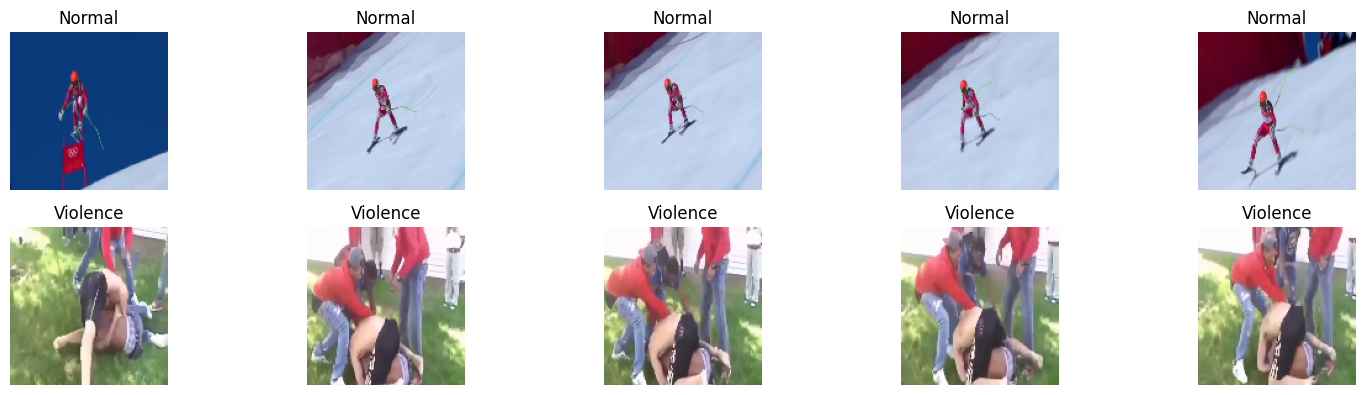

In [7]:
plt.figure(figsize=(15,6))

# Normal frames
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(NonViolence[-i])
    plt.title("Normal")
    plt.axis('off')

# Violence frames
for i in range(5):
    plt.subplot(3, 5, i + 6)
    plt.imshow(Violence[-i])
    plt.title("Violence")
    plt.axis('off')

# # Weaponized frames
# for i in range(5):
#     plt.subplot(3, 5, i + 11)
#     plt.imshow(weaponized[-i])
#     plt.title("Weaponized")
#     plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
scvd_train_dir = 'C:\\Users\\manas\\Downloads\\violence_detection_dataset\\real life violence situations\\Real Life Violence Dataset'
scvd_test_dir = 'C:\\Users\\manas\\Downloads\\violence_detection_dataset\\Real Life Violence Dataset'
scvd_classes = ['Violence', 'NonViolence']
print('done')

done


In [9]:
X_train,y_train = extract_frames(scvd_train_dir)
X_test,y_test = extract_frames(scvd_test_dir)
print('done')

done


In [10]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1300, 15, 128, 128, 3), (1300,), (1300, 15, 128, 128, 3), (1300,))

In [11]:
np.unique(y_train)

array(['NonViolence', 'Violence'], dtype='<U11')

In [118]:
# y_train = np.where(y_train == 'Weaponized','Violence',y_train)

# y_test = np.where(y_test == 'Weaponized','Violence',y_test)

In [12]:
X_example = X_train[y_train == 'Violence']  # Filter X_train where y_train is 'Violence'
print(np.mean(X_example))  # Compute mean of filtered values

0.3885304909341864


In [19]:
np.unique(y_train)

array(['NonViolence', 'Violence'], dtype='<U11')

In [11]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, TimeDistributed, GlobalAveragePooling2D, 
                                     LSTM, Dense, Dropout, BatchNormalization)

# Load MobileNetV2 as a feature extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Prevent downsampling in the first conv layer
base_model.layers[0].strides = (1, 1)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define model input (sequence of 15 frames)
input_layer = Input(shape=(15, 128, 128, 3))

# Apply MobileNetV2 to each frame
x = TimeDistributed(base_model)(input_layer)
x = TimeDistributed(GlobalAveragePooling2D())(x)  # Convert (128,128,1280) → (1280)

# LSTM layers for sequence modeling
x = LSTM(128, return_sequences=True)(x)
x = LSTM(64, return_sequences=False)(x)

# Fully connected layers
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)  # ✅ Normalizes activations
x = Dropout(0.3)(x)          # ✅ Prevents overfitting

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)  # ✅ Keeps activations stable

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)          # ✅ Light Dropout for regularization

# Output layer (Binary classification)
output_layer = Dense(1, activation='sigmoid')(x)

# Build the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()



# import tensorflow as tf
# from tensorflow.keras import backend as K

# def focal_loss(alpha=0.25, gamma=2.0):
#     def loss(y_true, y_pred):
#         y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
#         pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
#         return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt))
#     return loss


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 15, 128, 128, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 15, 4, 4, 1280)      │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 15, 1280)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 15, 128)             │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,088,193 (11.78 MB)

 Trainable params: 829,441 (3.16 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [13]:
import numpy as np

# Convert to NumPy arrays
X_train_np = np.array(X_train, dtype=np.float32)
y_train_np = np.array(y_train, dtype=np.float32)


print(X_train_np.shape, y_train_np.shape)

print(f"X_train_np shape: {X_train_np.shape}, dtype: {X_train_np.dtype}")
print(f"y_train_np shape: {y_train_np.shape}, dtype: {y_train_np.dtype}")



(1300, 15, 128, 128, 3) (1300,)
X_train_np shape: (1300, 15, 128, 128, 3), dtype: float32
y_train_np shape: (1300,), dtype: float32


In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('C:\\New folder (3)\\cctvmodel.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
)

In [16]:
# Ensure at least 1 training sample
val_split = max(1, int(0.2 * len(X_train_np)))
train_size = len(X_train_np) - val_split

# Correctly split training and validation sets
X_train_final, X_val = X_train_np[:train_size], X_train_np[train_size:]
y_train_final, y_val = y_train_np[:train_size], y_train_np[train_size:]

# ✅ Reshape labels
y_train_final = y_train_final.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

# Check shapes before training
print(f"Training Data: {X_train_final.shape}, Labels: {y_train_final.shape}")
print(f"Validation Data: {X_val.shape}, Labels: {y_val.shape}")

# Train model
model.fit(X_train_final, y_train_final, validation_data=(X_val, y_val),
          callbacks=[early_stopping, checkpoint], epochs=30, batch_size=8)


Training Data: (1040, 15, 128, 128, 3), Labels: (1040, 1)
Validation Data: (260, 15, 128, 128, 3), Labels: (260, 1)
Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 201s 978ms/step - accuracy: 0.6866 - loss: 0.5927 - val_accuracy: 0.0923 - val_loss: 0.9033
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 741ms/step - accuracy: 0.9080 - loss: 0.2492 - val_accuracy: 0.4308 - val_loss: 1.0406
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 739ms/step - accuracy: 0.9241 - loss: 0.2183 - val_accuracy: 0.6269 - val_loss: 0.7522
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 737ms/step - accuracy: 0.9352 - loss: 0.1740 - val_accuracy: 0.4846 - val_loss: 1.2390
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 95s 733ms/step - accuracy: 0.9730 - loss: 0.0890 - val_accuracy: 0.5346 - val_loss: 1.5576
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 94s 724ms/step - accuracy: 0.9402 - loss: 0.1716 - val_accuracy: 0.3038 - val_loss: 5.2073
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 94s 726ms/step - accuracy: 0.9508 - loss: 0.1238 - val_ac

In [214]:
model.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4975 - loss: 0.0403


[0.037047021090984344, 0.5731707215309143]

In [12]:
# # prompt: write a code to access webcam through opencv in python


import cv2 

def access_webcam():
    # Initialize the webcam
    cap = cv2.VideoCapture(0)  # 0 typically refers to the default webcam
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('C:\\Users\\manas\\Downloads\\outVid.avi', fourcc, 5.0, (640, 480))
    frames = []
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break
        resized_image = cv2.resize(frame, (128, 128))
        out.write(resized_image)
        frames.append(resized_image)

        # Display the frame
        cv2.imshow('Webcam Feed', frame)

        # Exit on pressing 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
   
    cv2.destroyAllWindows()
    print(out)
    print(type(out))
    print(out.isOpened())
    return frames

# cap = cv2.VideoCapture(0)
# while True :
#     ret,frame = cap.read()

#     cv2.imshow('Webcam Feed', frame)
#     print(ret)
#     if cv2.waitKey(1) & 0xFF == ord('x'):
#       break
# cap.release()
# cv2.destroyAllWindows()




# from IPython.display import display, Javascript
# from google.colab.output import eval_js
# from base64 import b64decode

# def take_photo(filename='photo.jpg', quality=0.8):
#   js = Javascript('''
#     async function takePhoto(quality) {
#       const div = document.createElement('div');
#       const capture = document.createElement('button');
#       capture.textContent = 'Capture';
#       div.appendChild(capture);

#       const video = document.createElement('video');
#       video.style.display = 'block';
#       const stream = await navigator.mediaDevices.getUserMedia({video: true});

#       document.body.appendChild(div);
#       div.appendChild(video);
#       video.srcObject = stream;
#       await video.play();

#       // Resize the output to fit the video element.
#       google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

#       // Wait for Capture to be clicked.
#       await new Promise((resolve) => capture.onclick = resolve);

#       const canvas = document.createElement('canvas');
#       canvas.width = video.videoWidth;
#       canvas.height = video.videoHeight;
#       canvas.getContext('2d').drawImage(video, 0, 0);
#       stream.getVideoTracks()[0].stop();
#       div.remove();
#       return canvas.toDataURL('image/jpeg', quality);
#     }
#     ''')
#   display(js)
#   data = eval_js('takePhoto({})'.format(quality))
#   binary = b64decode(data.split(',')[1])
#   with open(filename, 'wb') as f:
#     f.write(binary)
#   return filename

In [4]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load trained model
model_path = r"C:\New folder (2)\cctvmodel.keras"  # Change to your model path
model = load_model(model_path)

# Define video path
video_path = r"C:\Users\manas\Downloads\violence_detection_dataset\Real Life Violence Dataset\NonViolence\NV_937.mp4"

# Function to load video and process frames
def load_video(video_path, frame_size=(128, 128), sequence_length=15):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Stop when video ends

        # Resize frame
        frame = cv2.resize(frame, frame_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frame = frame / 255.0  # Normalize to [0,1]
        frames.append(frame)

    cap.release()
    frames = np.array(frames, dtype=np.float32)
    print(f"Total frames loaded: {frames.shape[0]}")

    return frames

# Process video frames
frames_np = load_video(video_path)  # Shape: (num_frames, 128, 128, 3)

# Ensure frames are enough for prediction
num_frames = frames_np.shape[0]
if num_frames < 15:
    print("Error: Video has fewer than 15 frames, cannot process.")
    exit()

# Sliding window approach to make predictions
predictions = []
for i in range(0, num_frames - 14, 5):  # Step size of 5 (adjust for real-time balance)
    sequence = frames_np[i : i + 15]  # Extract a 15-frame sequence
    sequence = np.expand_dims(sequence, axis=0)  # Reshape to (1, 15, 128, 128, 3)

    pred = model.predict(sequence)[0][0]  # Get scalar output
    predictions.append(pred)

# Compute final prediction
average_prediction = np.median(predictions)
print(f"Average Prediction Score: {average_prediction:.4f}")

# Convert prediction to label
final_prediction = "violence" if average_prediction > 0.5 else "non-violence"
print(f"Final Classification: {final_prediction}")


Total frames loaded: 145
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1

In [44]:
import numpy as np

path = "C:\\archive\\SCVD\\SCVD_converted\\Test\\Violence\\t_v001_converted.avi"
a = load_video(path)  # Assuming load_video returns frames in (num_frames, height, width, channels)

pathz = np.array(a, dtype=np.float32)  # Convert to NumPy array
print(pathz.shape)  # Check the shape of loaded frames

# Ensure we have enough frames for sequence input
sequence_length = 15
num_frames = pathz.shape[0]

# Reshape into sequences of 15 frames
if num_frames >= sequence_length:
    sequences = [
        pathz[i : i + sequence_length] for i in range(0, num_frames - sequence_length + 1, sequence_length)
    ]
    sequences = np.array(sequences)  # Convert to NumPy array

    print(sequences.shape)  # Expected shape: (num_sequences, 15, 128, 128, 3)

    # Make predictions
    predictions = model.predict(sequences)  # Model expects batch input

    # Calculate the average prediction across all sequences
    average_prediction = np.mean(predictions)
    print("Average Prediction:", average_prediction)

    # Classification threshold
    final_prediction = "violence" if average_prediction < 0.62 else "non-violence"
    print("Final Prediction:", final_prediction)
else:
    print("Not enough frames to form a sequence for prediction.")
print(sequences)


(15, 128, 128, 3)
(1, 15, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Average Prediction: 0.63379526
Final Prediction: non-violence
[[[[[0.         0.         0.        ]
    [0.         0.         0.        ]
    [0.         0.         0.        ]
    ...
    [0.         0.         0.        ]
    [0.         0.         0.        ]
    [0.         0.         0.        ]]

   [[0.         0.         0.        ]
    [0.         0.         0.        ]
    [0.         0.         0.        ]
    ...
    [0.         0.         0.        ]
    [0.         0.         0.        ]
    [0.         0.         0.        ]]

   [[0.         0.         0.        ]
    [0.         0.         0.        ]
    [0.         0.         0.        ]
    ...
    [0.         0.         0.        ]
    [0.         0.         0.        ]
    [0.         0.         0.        ]]

   ...

   [[0.         0.         0.        ]
    [0.         0.         0.        ]
    [0.         0.         0.        ]
   

In [250]:
prediction = model.predict(video_frames)
if prediction > 0.5:
    print("violence detected")
else :
    print("no violence detected")
    
print("Prediction:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
violence detected
Prediction: [[0.5448825]]


In [1]:
from tensorflow.keras.models import load_model

# Load the model without strict config enforcement
model = load_model(r"C:\New folder (2)\cctvmodel.keras", compile=False)

# # Manually recompile it with the custom loss
# model.compile(loss=custom_loss, optimizer="adam")

# # Save it again
# model.save(r"C:\New folder (2)\cctvmodel.keras")


In [27]:


# Initialize video capture (0 for default webcam)
cap = cv2.VideoCapture(0)


# Buffer to store last 15 frames
frame_buffer = []

# Define frame size and count
frame_count = 15
frame_size = (128, 128)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Resize frame to match model input
    frame_resized = cv2.resize(frame, frame_size)
    frame_resized = frame_resized.astype(np.float32) / 255.0  # Normalize to [0,1]
    
    # Append to buffer
    frame_buffer.append(frame_resized)
    
    # Keep only the last 15 frames
    if len(frame_buffer) > frame_count:
        frame_buffer.pop(0)

    # Ensure we have exactly 15 frames before making a prediction
    if len(frame_buffer) == frame_count:
        # Convert to NumPy array and reshape for model input
        video_frames = np.expand_dims(np.array(frame_buffer), axis=0)  # Shape: (1,15,128,128,3)

        # Make prediction
        prediction = model.predict(video_frames)[0][0]  # Assuming binary classification (0: Normal, 1: Violence)
        print(prediction)
        
        # Display prediction result
        label = "Violence Detected!" if prediction > 0.032 else "Normal"
        color = (0, 0, 255) if prediction > 0.032 else (0, 255, 0)

        # Overlay text on frame
        cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

    # Show frame
    cv2.imshow("Webcam Violence Detection", frame)

    # Exit on 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release webcam and close windows
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
0.015770938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
0.0153216915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
0.014776436
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
0.015395476
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
0.0155328885
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
0.015532612
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
0.015669059
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
0.016208194
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
0.01559849
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
0.015932396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
0.015760938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
0.015569756
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
0.015325188
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
0.015404462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
0.015406074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
0.015762147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
0.015700215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
0.016290316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
0.016956504
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
0.015114047